## General network properties: Articulation points and bridges

In [1]:

import pandas as pd
import seaborn as sns

import config
from config import GRAPHS_PATH
from lib.graph_database_access import get_pathways
from lib.networks import get_interactomes, get_multiindex, get_combinations

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

config.set_root_wd()

Working directory: c:\git\pathwayanalysisplatform\proteoformnetworks


## For each interactome

In [2]:
index = get_multiindex()
interactomes_no_sm, interactomes_with_sm, interactomes_with_unique_sm = get_interactomes(GRAPHS_PATH)
interactomes = [*interactomes_no_sm.values(), *interactomes_with_sm.values(), *interactomes_with_unique_sm.values()]

In [3]:
import decimal
from statistics import mean

columns = [
    "Number of Articulation Points",
    "Percentage articulation point nodes",
    "Number of accessioned entities articulation points",
    "Percentage of accessioned entities articulation points",
    "Number of small molecules articulation points",
    "Percentage of small molecules articulation points",
    "Number of interactions",
    "Number of bridge interactions",
    "Percentage of links that are bridges",
    "Percentage of links coming out of the accessioned entities that are bridges",
    "Percentage of links coming out of the small molecules that are bridges"
]


def count_accessioned_entites_art_points(g):
    return sum(g.nodes[n]["Articulation Point"] and not g.nodes[n]['type'].startswith("Simple") for n in g.nodes)


def count_small_molecules_art_points(g):
    return sum(g.nodes[n]["Articulation Point"] and g.nodes[n]['type'].startswith("Simple") for n in g.nodes)


def get_percentage_links_that_are_bridges(g, nodes):
    percentage_bridges_from_node = []
    for node in nodes:
        if len(g.edges(node)) > 0:
            num_bridges = sum(g.edges[e]['Bridge'] for e in g.edges(node))
            percentage_bridges_from_node.append(num_bridges / len(g.edges(node)))
        else:
            percentage_bridges_from_node.append(0)
    return mean(percentage_bridges_from_node)


def get_tuples(interactome):
    percentage_art_points = interactome.graph['Articulation Points'] / interactome.number_of_nodes()
    num_acc_ent_art_points = count_accessioned_entites_art_points(interactome)
    percentage_acc_ent_art_points = num_acc_ent_art_points / interactome.graph['num_entities']
    num_sm_art_points = count_small_molecules_art_points(interactome)
    percentage_sm_art_points = 0
    if interactome.graph['num_small_molecules'] > 0:
        percentage_sm_art_points = num_sm_art_points / interactome.graph['num_small_molecules']
    assert interactome.graph['Articulation Points'] == num_acc_ent_art_points + num_sm_art_points

    percentage_bridges = round(decimal.Decimal(interactome.graph["Bridges"]) / interactome.number_of_edges(), 5)
    acc_ents = list(interactome.nodes)
    percentage_from_sms = 0
    if interactome.graph['num_small_molecules'] > 0:
        acc_ents = [n for n in interactome.nodes if not interactome.nodes[n]['type'].startswith("Simple")]
        sms = [n for n in interactome.nodes if interactome.nodes[n]['type'].startswith("Simple")]
        percentage_from_sms = get_percentage_links_that_are_bridges(interactome, sms)
    percentage_from_acc_ents = get_percentage_links_that_are_bridges(interactome, acc_ents)

    return (
        interactome.graph['Articulation Points'],
        percentage_art_points,
        num_acc_ent_art_points,
        percentage_acc_ent_art_points,
        num_sm_art_points,
        percentage_sm_art_points,
        interactome.number_of_edges(),
        interactome.graph["Bridges"],
        percentage_bridges,
        percentage_from_acc_ents,
        percentage_from_sms
    )


df_br_ap = pd.DataFrame([get_tuples(interactome) for interactome in interactomes],
                        columns=columns,
                        index=index)
df_br_ap

Number of Articulation Points  \
Small Molecules          Entity Level                                  
Not Included             genes                                   269   
                         proteins                                270   
                         proteoforms                             349   
Included                 genes                                   246   
                         proteins                                246   
                         proteoforms                             255   
Reaction-Unique Included genes                                  1889   
                         proteins                               1888   
                         proteoforms                            1919   

                                       Percentage articulation point nodes  \
Small Molecules          Entity Level                                        
Not Included             genes                                        0.02   
                         proteins                                     0.02   
                         proteoforms                                  0.02   
Included                 genes                                        0.02   
                         proteins                                     0.02   
                         proteoforms                                  0.02   
Reaction-Unique Included genes                                        0.05   
                         proteins                                     0.05   
                         proteoforms                                  0.05   

                                       Number of accessioned entities articulation points  \
Small Molecules          Entity Level                                                       
Not Included             genes                                                       269    
                         proteins                                                    270    
                         proteoforms                                                 349    
Included                 genes                                                       145    
                         proteins                                                    145    
                         proteoforms                                                 153    
Reaction-Unique Included genes                                                      1486    
                         proteins                                                   1485    
                         proteoforms                                                1516    

                                       Percentage of accessioned entities articulation points  \
Small Molecules          Entity Level                                                           
Not Included             genes                                                      0.02        
                         proteins                                                   0.02        
                         proteoforms                                                0.02        
Included                 genes                                                      0.01        
                         proteins                                                   0.01        
                         proteoforms                                                0.01        
Reaction-Unique Included genes                                                      0.14        
                         proteins                                                   0.13        
                         proteoforms                                                0.11        

                                       Number of small molecules articulation points  \
Small Molecules          Entity Level                                                  
Not Included             genes                                                     0   
                         protei

In [4]:
data = {
    "Bottleneck": ["Articulation Points"] * 9,
    "Percentage": df_br_ap["Percentage articulation point nodes"]
}
df_art_points = pd.DataFrame(data)
df_art_points.reset_index(inplace=True)

data = {
    "Bottleneck": ["Bridges"] * 9,
    "Percentage": df_br_ap["Percentage of links that are bridges"]
}
df_bridges = pd.DataFrame(data)
df_bridges.reset_index(inplace=True)

data_br_ap = pd.concat([df_art_points, df_bridges])
data_br_ap

,Small Molecules,Entity Level,Bottleneck,Percentage
0,Not Included,genes,Articulation Points,0.02
1,Not Included,proteins,Articulation Points,0.02
2,Not Included,proteoforms,Articulation Points,0.02
3,Included,genes,Articulation Points,0.02
4,Included,proteins,Articulation Points,0.02
5,Included,proteoforms,Articulation Points,0.02
6,Reaction-Unique Included,genes,Articulation Points,0.05
7,Reaction-Unique Included,proteins,Articulation Points,0.05
8,Reaction-Unique Included,proteoforms,Articulation Points,0.05
0,Not Included,genes,Bridges,0.00114


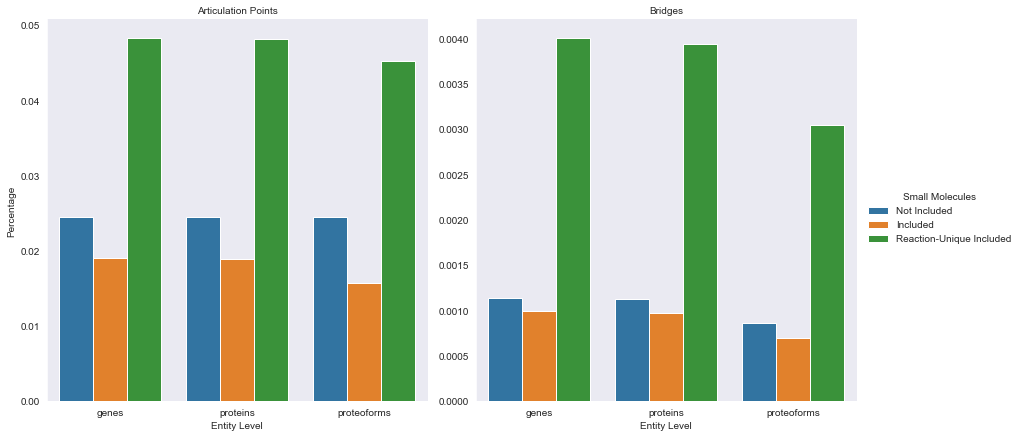

In [5]:
sns.set_style("dark")
f = sns.catplot(x="Entity Level",
                y="Percentage",
                hue="Small Molecules",
                col="Bottleneck",
                data=data_br_ap,
                kind="bar",
                height=6, aspect=1, sharey=False)
f.set_titles("{col_name}")

## For each pathway

In [6]:
from lib.networks import create_pathway_interaction_network
from config import LEVELS, METHODS

# Create all pathway networks
# Sets each node as node as articulation points or not
# Sets each edge as bridge or not
df_pathways = get_pathways()
#for pathway in df_pathways["stId"]:
#    create_pathway_interaction_networks(pathway, "resources/pathway_networks/")
df_pathways

,stId,displayName
0,R-HSA-9613829,Chaperone Mediated Autophagy
1,R-HSA-1632852,Macroautophagy
2,R-HSA-5205685,PINK1-PRKN Mediated Mitophagy
3,R-HSA-8934903,Receptor Mediated Mitophagy
4,R-HSA-9613354,Lipophagy
...,...,...
2060,R-HSA-432722,Golgi Associated Vesicle Biogenesis
2061,R-HSA-432720,Lysosome Vesicle Biogenesis
2062,R-HSA-8856828,Clathrin-mediated endocytosis
2063,R-HSA-8856825,Cargo recognition for clathrin-mediated endocy...


In [7]:


combinations = get_combinations(50)
combinations[0:30]

TypeError: get_combinations() takes 0 positional arguments but 1 was given

In [ ]:
columns = [
    "Small Molecules", "Entity Level", "Pathway",
    "Number of nodes", "Number of articulation point nodes", "Percentage of articulation point nodes",
    "Number of accessioned entities articulation points", "Percentage of accessioned entities articulation points",
    "Number of small molecule articulation points", "Percentage of small molecules that are articulation points",

    "Number of links", "Number of links bridges", "Percentage of bridge links",
    "Percentage of bridge links from accessioned entities",
    "Percentage of bridge links from small molecules"
]

out_path = "resources/pathway_networks/"


def get_tuples(combination):
    G = create_pathway_interaction_network(
        method=combination[0], level=combination[1], pathway=combination[2], out_path=out_path
    )

    percentage_art_points = G.graph['Articulation Points'] / G.number_of_nodes()
    num_acc_ent_art_points = count_accessioned_entites_art_points(G)
    percentage_acc_ent_art_points = num_acc_ent_art_points / G.graph['num_entities']
    num_sm_art_points = count_small_molecules_art_points(G)
    percentage_sm_art_points = 0
    if G.graph['num_small_molecules'] > 0:
        percentage_sm_art_points = num_sm_art_points / G.graph['num_small_molecules']
    assert G.graph['Articulation Points'] == num_acc_ent_art_points + num_sm_art_points

    percentage_bridges = 0
    if G.number_of_edges() > 0:
        percentage_bridges = round(decimal.Decimal(G.graph["Bridges"]) / G.number_of_edges(), 5)
    acc_ents = list(G.nodes)
    percentage_from_sms = 0
    if G.graph['num_small_molecules'] > 0:
        acc_ents = [n for n in G.nodes if not G.nodes[n]['type'].startswith("Simple")]
        sms = [n for n in G.nodes if G.nodes[n]['type'].startswith("Simple")]
        percentage_from_sms = get_percentage_links_that_are_bridges(G, sms)
    percentage_from_acc_ents = get_percentage_links_that_are_bridges(G, acc_ents)

    return (
        combination[0], combination[1], combination[2],
        G.number_of_nodes(), G.graph['Articulation Points'], percentage_art_points,
        num_acc_ent_art_points, percentage_acc_ent_art_points,
        num_sm_art_points, percentage_sm_art_points,

        G.number_of_edges(), G.graph["Bridges"], float(percentage_bridges),
        percentage_from_acc_ents,
        percentage_from_sms
    )

In [ ]:
df_br_ap_pathways = pd.DataFrame([get_tuples(combination) for combination in combinations], columns=columns)
df_br_ap_pathways

In [ ]:
df_br_ap_pathways.dtypes

In [ ]:
df_pathways_grouped = df_br_ap_pathways.groupby(['Small Molecules', 'Entity Level']).agg(
    {
        "Number of nodes": ['mean'],
        "Number of articulation point nodes": ['mean'],
        "Percentage of articulation point nodes": ['mean'],
        "Number of accessioned entities articulation points": ['mean'],
        "Percentage of accessioned entities articulation points": ['mean'],
        "Number of small molecule articulation points": ['mean'],
        "Percentage of small molecules that are articulation points": ['mean'],
        "Number of links": ['mean'],
        "Number of links bridges": ['mean'],
        "Percentage of bridge links": ['mean'],
        "Percentage of bridge links from accessioned entities": ['mean'],
        "Percentage of bridge links from small molecules": ['mean']
    })
df_pathways_grouped.columns = [
    "Number of nodes", "Number of articulation point nodes", "Percentage of articulation point nodes",
    "Number of accessioned entities articulation points", "Percentage of accessioned entities articulation points",
    "Number of small molecule articulation points", "Percentage of small molecules that are articulation points",
    "Number of links", "Number of links bridges", "Percentage of bridge links",
    "Percentage of bridge links from accessioned entities",
    "Percentage of bridge links from small molecules"
]
df_pathways_grouped = df_pathways_grouped.set_index(get_multiindex())

df_pathways_grouped

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
fig.set_size_inches(10, 6)
f = sns.violinplot(x="Small Molecules", y="Percentage of articulation point nodes", hue="Entity Level",
                   data=df_br_ap_pathways, palette=config.COLORS_BORDER)
#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$")) # Convert ticks to powers of 10
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("Percentage of articulation point nodes in Pathways")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 6))
fig.set_size_inches(10, 6)
df_br_ap_pathways["Percentage of bridge links"] = df_br_ap_pathways["Percentage of bridge links"].astype('float64')
f2 = sns.violinplot(x="Small Molecules", y="Percentage of bridge links", hue="Entity Level",
                    data=df_br_ap_pathways, palette=config.COLORS_BORDER)
f2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f2.set_title("Percentage of bridge links in Pathways")

In [ ]:
data = {
    "Bottleneck": ["Articulation Points"] * len(df_br_ap_pathways),
    "Small Molecules": df_br_ap_pathways["Small Molecules"],
    "Entity Level": df_br_ap_pathways["Entity Level"],
    "Pathway": df_br_ap_pathways["Pathway"],
    "Percentage": df_br_ap_pathways["Percentage of articulation point nodes"]
}
df_art_points = pd.DataFrame(data)
df_art_points

In [ ]:
data = {
    "Bottleneck": ["Bridges"] * len(df_br_ap_pathways),
    "Small Molecules": df_br_ap_pathways["Small Molecules"],
    "Entity Level": df_br_ap_pathways["Entity Level"],
    "Pathway": df_br_ap_pathways["Pathway"],
    "Percentage": df_br_ap_pathways["Percentage of bridge links"]
}
df_bridges = pd.DataFrame(data)
df_bridges

In [ ]:
data_br_ap = pd.concat([df_art_points, df_bridges])
data_br_ap

In [ ]:
sns.set_style("dark")
f = sns.catplot(x="Entity Level",
                y="Percentage",
                hue="Small Molecules",
                col="Bottleneck",
                data=data_br_ap,
                kind="violin",
                height=6, aspect=1, sharey=False)
f.set_titles("{col_name}")